<a href="https://colab.research.google.com/github/francismcguire/CNN_Food101/blob/master/AI_food_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Loading necessary libraries

In [0]:
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import regularizers
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D, AveragePooling2D, Conv2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l2
from tensorflow import keras
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.image as img
%matplotlib inline
from collections import defaultdict
import collections
from shutil import copy
from shutil import copytree, rmtree



In [0]:
#data download and extraction
# ETA for data download is approximately 20-25 minutes therefore a function has been created that checks if data is already downloaded then
# it is not redownloaded again 

def data():
  if "food-101" in os.listdir():
    print("Data exists do not redownload, please save time!")
  else:
    !wget http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz
    !tar xzvf food-101.tar.gz

In [0]:
data()

Streaming output truncated to the last 5000 lines.
food-101/images/cannoli/1767088.jpg
food-101/images/cannoli/3201965.jpg
food-101/images/cannoli/3778102.jpg
food-101/images/cannoli/2674065.jpg
food-101/images/cannoli/1169899.jpg
food-101/images/cannoli/1378086.jpg
food-101/images/cannoli/803909.jpg
food-101/images/cannoli/1067240.jpg
food-101/images/cannoli/3002709.jpg
food-101/images/cannoli/2612632.jpg
food-101/images/cannoli/3627612.jpg
food-101/images/cannoli/1798703.jpg
food-101/images/cannoli/560632.jpg
food-101/images/cannoli/512468.jpg
food-101/images/cannoli/2331523.jpg
food-101/images/cannoli/3118302.jpg
food-101/images/cannoli/1499412.jpg
food-101/images/cannoli/1557459.jpg
food-101/images/cannoli/146566.jpg
food-101/images/cannoli/96922.jpg
food-101/images/cannoli/1699562.jpg
food-101/images/cannoli/730051.jpg
food-101/images/cannoli/2177977.jpg
food-101/images/cannoli/2767028.jpg
food-101/images/cannoli/6564.jpg
food-101/images/cannoli/553447.jpg
food-101/images/cannoli/

# New Section

In [0]:
#displaying some food items from the image list

os.listdir('food-101/images')[10]

'breakfast_burrito'

In [0]:
os.listdir('food-101/images')[20]


'ramen'

In [0]:
os.listdir('food-101/images')[72]


'macaroni_and_cheese'

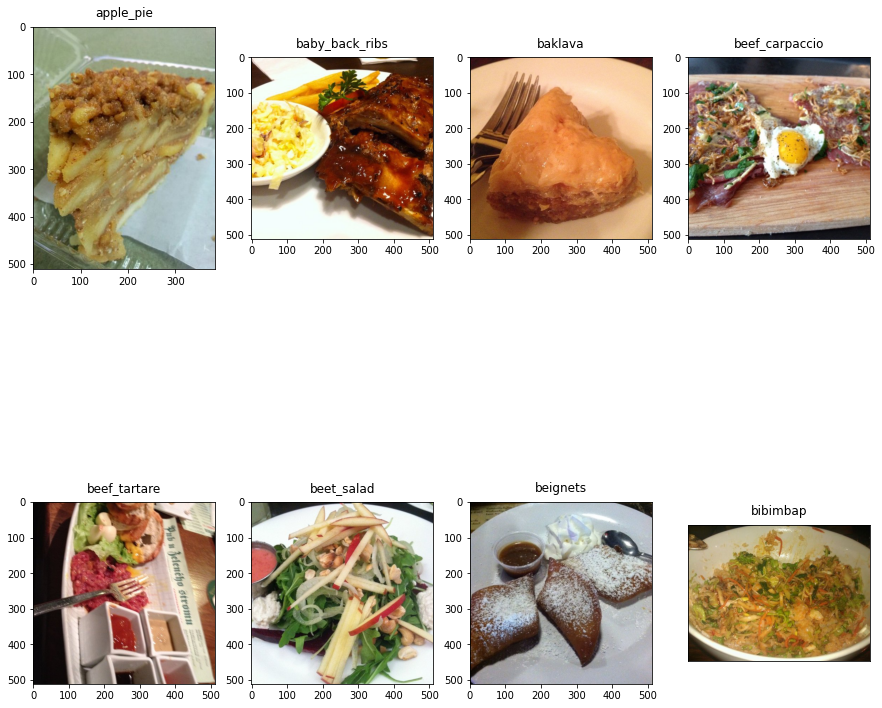

In [0]:
#visualization of food images in the dataset food-101

fig, ax = plt.subplots(2, 4, figsize=(15,15))
img_data = "food-101/images/"
sort = sorted(os.listdir(img_data))
food_id = 0
for i in range(2):
  for j in range(4):
    try:
      food_selected = sort[food_id] 
      food_id += 1
    except:
      break
    images = os.listdir(os.path.join(img_data,food_selected)) 
    random = np.random.choice(images) 
    img = plt.imread(os.path.join(img_data,food_selected, random))
    ax[i][j].imshow(img)
    ax[i][j].set_title(food_selected, pad = 10)
    
  plt.xticks([])
  plt.yticks([])



In [0]:

# data preparation and copying data into train and test datasets
#fp - filename, src- source, dest- destination

def prep(fp,src,destination):
  img_per_class = defaultdict(list)
  with open(fp, 'r') as txt:
      paths = [read.strip() for read in txt.readlines()]
      for p in paths:
        food = p.split('/')
        img_per_class[food[0]].append(food[1] + '.jpg')

  for food in img_per_class.keys():
#    print("\n Display food copied ",food)         #if in case you wish to see what food items are being copied
    if not os.path.exists(os.path.join(destination,food)):
      os.makedirs(os.path.join(destination,food))
    for i in img_per_class[food]:
      copy(os.path.join(src,food,i), os.path.join(destination,food,i))


In [0]:
# Prepare train dataset by copying images from food-101/images to food-101/train using the file train.txt
prep('food-101/meta/train.txt', 'food-101/images', 'food-101/train')

In [0]:
# Prepare test data by copying images from food-101/images to food-101/test using the file test.txt
prep('food-101/meta/test.txt', 'food-101/images', 'food-101/test')

In [0]:
#creating train_small and test_small data samples for easy processing. 
#this is done so that only a few images are fit into the model instead of the whole of 75750

# fl - food list, src - source, dest - destination
def small_set(fl, src, destination):
  if os.path.exists(destination):
    rmtree(destination) 
  os.makedirs(destination)
  for food_item in fl :
    print("food item selected for the model:",food_item)
    copytree(os.path.join(src,food_item), os.path.join(destination,food_item))
      

In [0]:
# picking 1 food item and generating separate data folders for the same
food_list = ['pancakes', 'beef_tartare']
X_train = 'food-101/train'         
X_train_small = 'food-101/train_small'            
X_test = 'food-101/test'
X_test_small = 'food-101/test_small'

In [0]:
#Creating train data folder for food_list
small_set(food_list, X_train, X_train_small)

food item selected for the model: pancakes
food item selected for the model: beef_tartare


In [0]:
#Creating test data folder for food_list
small_set(food_list, X_test, X_test_small)

food item selected for the model: pancakes
food item selected for the model: beef_tartare


In [0]:
#building model

K.clear_session()

n_classes = 2
img_w, img_h = 299, 299
train_data = 'food-101/train_small'
validation_data = 'food-101/test_small'
nb_train_samples = 2000
nb_validation_samples = 500 
batch_size = 100
epochs=40
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    train_data,
    target_size=(img_h, img_w),
    batch_size=batch_size,
    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
    validation_data,
    target_size=(img_h, img_w),
    batch_size=batch_size,
    class_mode='binary')



Found 1500 images belonging to 2 classes.
Found 500 images belonging to 2 classes.


In [0]:
if K.image_data_format() == 'channels_first': 
    input_shape = (3, img_w, img_h ) 
else: 
    input_shape = (img_w, img_h, 3) 
  
model = Sequential() 
model.add(Conv2D(32, (2, 2), input_shape = input_shape)) 
model.add(Activation('relu')) 
model.add(MaxPooling2D(pool_size =(2, 2))) 
  
model.add(Conv2D(32, (2, 2))) 
model.add(Activation('relu')) 
model.add(MaxPooling2D(pool_size =(2, 2))) 
  
model.add(Conv2D(64, (2, 2))) 
model.add(Activation('relu')) 
model.add(MaxPooling2D(pool_size =(2, 2))) 
  
model.add(Flatten()) 
model.add(Dense(64)) 
model.add(Activation('relu')) 
model.add(Dropout(0.5)) 
model.add(Dense(1)) 
model.add(Activation('sigmoid')) 
  
model.compile(loss ='binary_crossentropy', 
                     optimizer ='rmsprop', 
                   metrics =['accuracy']) 
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 298, 298, 32)      416       
_________________________________________________________________
activation (Activation)      (None, 298, 298, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 149, 149, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 148, 148, 32)      4128      
_________________________________________________________________
activation_1 (Activation)    (None, 148, 148, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 73, 73, 64)        8

In [0]:
history =model.fit_generator(train_generator, 
    steps_per_epoch = nb_train_samples // batch_size, 
    epochs = epochs, validation_data = validation_generator, 
    validation_steps = nb_validation_samples // batch_size) 

Epoch 1/40
20/20 [==============================] - 42s 2s/step - loss: 1.1447 - accuracy: 0.5095 - val_loss: 0.6934 - val_accuracy: 0.5000
Epoch 2/40
20/20 [==============================] - 41s 2s/step - loss: 0.6802 - accuracy: 0.5675 - val_loss: 0.6335 - val_accuracy: 0.6720
Epoch 3/40
20/20 [==============================] - 41s 2s/step - loss: 0.6443 - accuracy: 0.6330 - val_loss: 0.5372 - val_accuracy: 0.7640
Epoch 4/40
20/20 [==============================] - 41s 2s/step - loss: 0.6305 - accuracy: 0.7080 - val_loss: 0.5005 - val_accuracy: 0.7740
Epoch 5/40
20/20 [==============================] - 41s 2s/step - loss: 0.5212 - accuracy: 0.7470 - val_loss: 0.4344 - val_accuracy: 0.8200
Epoch 6/40
20/20 [==============================] - 41s 2s/step - loss: 0.5355 - accuracy: 0.7490 - val_loss: 0.5029 - val_accuracy: 0.7500
Epoch 7/40
20/20 [==============================] - 41s 2s/step - loss: 0.4995 - accuracy: 0.7685 - val_loss: 0.4397 - val_accuracy: 0.8260
Epoch 8/40
20/20 [==

In [0]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

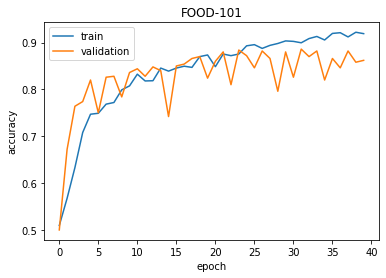

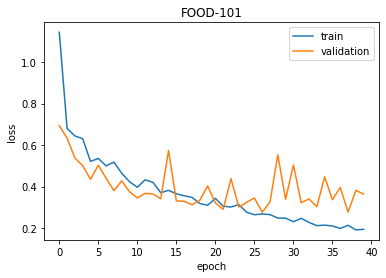

In [0]:
def plot_accuracy(history,title):
    plt.title(title)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='best')
    plt.show()
def plot_loss(history,title):
    plt.title(title)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='best')
    plt.show()


plot_accuracy(history,'FOOD-101')
plot_loss(history,'FOOD-101')